In [1]:
import time
from pathlib import Path
import fasttext
from huggingface_hub import hf_hub_download
import numpy as np
import pandas as pd
import pycountry
import py3langid as langid
import langid
import torch
from datasets import load_dataset,  get_dataset_config_names, Dataset
from sklearn.metrics import f1_score, accuracy_score, classification_report
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding, 
    pipeline,
    Trainer,
    TrainingArguments
)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
from tqdm import tqdm


c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\4247645975.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  

In [2]:


read_csv = pd.read_csv('flores_codes.txt', sep="\t",header=None)
csv_dict = read_csv.set_index(1)[0].to_dict()


In [20]:
read_csv_other = pd.read_csv('flores_lang_codes.txt', sep="\t",header=None)
csv_dict_langs = read_csv_other.set_index(1)[0].to_dict()

In [22]:
print(csv_dict_langs)

{'ace_Arab': 'Acehnese (Arabic script)', 'ace_Latn': 'Acehnese (Latin script)', 'acm_Arab': 'Mesopotamian Arabic', 'acq_Arab': 'Ta’izzi-Adeni Arabic', 'aeb_Arab': 'Tunisian Arabic', 'afr_Latn': 'Afrikaans', 'ajp_Arab': 'South Levantine Arabic', 'aka_Latn': 'Akan', 'amh_Ethi': 'Amharic', 'apc_Arab': 'North Levantine Arabic', 'arb_Arab': 'Modern Standard Arabic', 'arb_Latn': 'Modern Standard Arabic (Romanized)', 'ars_Arab': 'Najdi Arabic', 'ary_Arab': 'Moroccan Arabic', 'arz_Arab': 'Egyptian Arabic', 'asm_Beng': 'Assamese', 'ast_Latn': 'Asturian', 'awa_Deva': 'Awadhi', 'ayr_Latn': 'Central Aymara', 'azb_Arab': 'South Azerbaijani', 'azj_Latn': 'North Azerbaijani', 'bak_Cyrl': 'Bashkir', 'bam_Latn': 'Bambara', 'ban_Latn': 'Balinese', 'bel_Cyrl': 'Belarusian', 'bem_Latn': 'Bemba', 'ben_Beng': 'Bengali', 'bho_Deva': 'Bhojpuri', 'bjn_Arab': 'Banjar (Arabic script)', 'bjn_Latn': 'Banjar (Latin script)', 'bod_Tibt': 'Standard Tibetan', 'bos_Latn': 'Bosnian', 'bug_Latn': 'Buginese', 'bul_Cyrl': 

In [3]:
CACHE_DIR = Path("IDP/cache")

In [4]:


model_path = hf_hub_download(repo_id="facebook/fasttext-language-identification", filename="model.bin")
model_text = fasttext.load_model(model_path)



In [5]:

dataset = load_dataset("gsarti/flores_101", 'all', 'devtest')
  
get_dataset_config_names("gsarti/flores_101")

# iterable_dataset = fleurs.shuffle(seed=42, buffer_size=1000)

# for i in range(10):
#     curr = next(iter(iterable_dataset))
#     print(curr['transcription'])
#     print(model.predict(curr['transcription']))
#     print(curr['language'])

['afr',
 'all',
 'amh',
 'ara',
 'asm',
 'ast',
 'azj',
 'bel',
 'ben',
 'bos',
 'bul',
 'cat',
 'ceb',
 'ces',
 'ckb',
 'cym',
 'dan',
 'deu',
 'ell',
 'eng',
 'est',
 'fas',
 'fin',
 'fra',
 'ful',
 'gle',
 'glg',
 'guj',
 'hau',
 'heb',
 'hin',
 'hrv',
 'hun',
 'hye',
 'ibo',
 'ind',
 'isl',
 'ita',
 'jav',
 'jpn',
 'kam',
 'kan',
 'kat',
 'kaz',
 'kea',
 'khm',
 'kir',
 'kor',
 'lao',
 'lav',
 'lin',
 'lit',
 'ltz',
 'lug',
 'luo',
 'mal',
 'mar',
 'mkd',
 'mlt',
 'mon',
 'mri',
 'msa',
 'mya',
 'nld',
 'nob',
 'npi',
 'nso',
 'nya',
 'oci',
 'orm',
 'ory',
 'pan',
 'pol',
 'por',
 'pus',
 'ron',
 'rus',
 'slk',
 'slv',
 'sna',
 'snd',
 'som',
 'spa',
 'srp',
 'swe',
 'swh',
 'tam',
 'tel',
 'tgk',
 'tgl',
 'tha',
 'tur',
 'ukr',
 'umb',
 'urd',
 'uzb',
 'vie',
 'wol',
 'xho',
 'yor',
 'zho_simpl',
 'zho_trad',
 'zul']

In [6]:
lang_names = []
devtest_dict = {}
devtest_dict['language'] = []
devtest_dict['sentence'] = []
# df  = pd.DataFrame(columns=['language', 'sentence'])
for c in dataset['devtest'].column_names:
        if 'sentence_' in c:
            lang_names.append(c[len('sentence_'):])
for r in dataset['devtest']:
    for lang in lang_names:
        if r['sentence_'+lang] != '':
            devtest_dict['language'].append(csv_dict[lang])
            devtest_dict['sentence'].append(r['sentence_'+lang])

df = pd.DataFrame(devtest_dict)

print(df.head())

print(df['language'].value_counts())

   language                                           sentence
0  afr_Latn  “Ons het nou 4-maand oue muise wat nie diabeti...
1  amh_Ethi  "አሁን የስኳር በሽተኛ ያልነበሩ አሁን ግን የሆኑ የ4-ወር-ዕድሜ ያላቸው...
2  arb_Arab  أضاف قائلاً، "لدينا الآن فئران تبلغ من العمر 4...
3  hye_Armn  «Մենք հիմա ունենք 4 ամսական մկներ, որոնք, նախկ...
4  asm_Beng  """আমাৰ এতিয়া 4 মাহ বয়সৰ নিগনীবোৰ আছে যিবোৰ আগ...
language
afr_Latn    1012
nso_Latn    1012
pan_Guru    1012
por_Latn    1012
pol_Latn    1012
            ... 
guj_Gujr    1012
ell_Grek    1012
deu_Latn    1012
kat_Geor    1012
zul_Latn    1012
Name: count, Length: 102, dtype: int64


In [7]:
predictions = []
predictions_nonfiltered = []
for i in df.index:
    predictions.append(model_text.predict(df['sentence'][i])[0][0].split('__label__')[1])
    predictions_nonfiltered.append(model_text.predict(df['sentence'][i])[0][0])

# print(predictions)
# languages = df['language']
# print(f1_score(languages, predictions, average='weighted'))

In [19]:
languages = df['language']
print(predictions[0:10])
classes = list(set(languages))
x = classification_report(languages, predictions, labels=classes,  output_dict=True)

langs = x.keys()
f1s = [x[l]['f1-score'] for l in langs]
recalls = [x[l]['recall'] for l in langs]
precisions = [x[l]['precision'] for l in langs]

# pandas_df = pd.DataFrame({'lang': langs, 'f1': f1s, 'recall': recalls, 'precision': precisions})

# pandas_df = pandas_df.sort_values(by='f1', ascending=True)
# # pandas_df = pandas_df.set_index('lang')
# # print(pandas_df)

# pandas_df.to_csv('fasttext_langid_flores_101.csv')

['afr_Latn', 'amh_Ethi', 'arb_Arab', 'hye_Armn', 'asm_Beng', 'ast_Latn', 'azj_Latn', 'bel_Cyrl', 'ben_Beng', 'hrv_Latn']


In [29]:
langs_new =[csv_dict_langs[l] for l in classes]

print(len(langs_new))

102


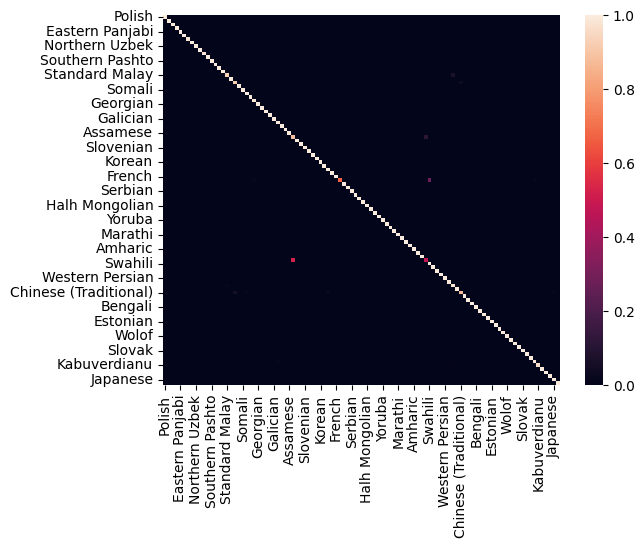

In [28]:
cm = confusion_matrix(languages,predictions, labels=classes, normalize='true')
df_cm = pd.DataFrame(cm, index = langs_new, columns = langs_new)
sns.heatmap(df_cm, annot=False)
plt.savefig("fasttext_confusion_matrix.png", dpi = 400)

In [12]:
sentences = df['sentence']

langid_predictions = []

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)

for s in sentences[:10]:
    langid_predictions.append(pipe(s)[0]['label'])

print(langid_predictions[0:10])
# print(f1_score(languages, langid_predictions, average='weighted'))

['nl', 'ur', 'ar', 'el', 'ur', 'es', 'tr', 'ru', 'hi', 'ur']


In [ ]:

classes = list(set(languages))

x = classification_report(languages, predictions, labels=classes,  output_dict=True)

pd.DataFrame(x).transpose().to_csv('fasttext_classification_report.csv')


In [ ]:
cm = confusion_matrix(languages,predictions, labels=classes, normalize='true')

df_cm = pd.DataFrame(cm, index = classes, columns = classes)

In [ ]:
sns.heatmap(df_cm, annot=False)

In [13]:
model_path = hf_hub_download(repo_id="cis-lmu/glotlid", filename="model.bin", cache_dir=None)

# load the model
model = fasttext.load_model(model_path)

model.bin: 100%|██████████| 1.69G/1.69G [00:36<00:00, 45.7MB/s]
c:\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ay07\.cache\huggingface\hub\models--cis-lmu--glotlid. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [14]:
predictions_glot = []
for i in df.index:
    predictions_glot.append(model.predict(df['sentence'][i])[0][0].split('__label__')[1])

In [18]:

classes = list(set(languages))

x_glot = classification_report(languages, predictions_glot, labels=classes,  output_dict=True)

pd.DataFrame(x_glot).transpose().to_csv('glotlid_classification_report.csv')


C:\Users\ay07\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ay07\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ay07\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


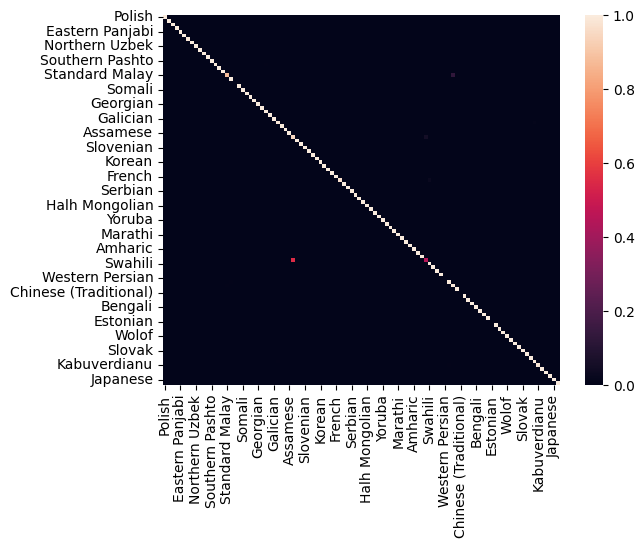

In [30]:
cm = confusion_matrix(languages,predictions_glot, labels=classes, normalize='true')
df_cm = pd.DataFrame(cm, index = langs_new, columns = langs_new)
sns.heatmap(df_cm, annot=False)
plt.savefig("glot_confusion_matrix.png", dpi = 400)

In [32]:
langs = x.keys()
f1s_glot = [x_glot[l]['f1-score'] for l in langs]
recalls_glot = [x_glot[l]['recall'] for l in langs]
precisions_glot = [x_glot[l]['precision'] for l in langs]


In [37]:
new_keys = []
for key in x.keys():
    if key in csv_dict_langs.keys():
        new_keys.append(csv_dict_langs[key])
    else:
        new_keys.append(key)

print(new_keys)

['Polish', 'Catalan', 'Burmese', 'Hausa', 'Eastern Panjabi', 'Maltese', 'Nigerian Fulfulde', 'Maori', 'Northern Uzbek', 'Sindhi', 'Umbundu', 'Northern Sotho', 'Southern Pashto', 'Danish', 'Romanian', 'Hungarian', 'Standard Malay', 'Spanish', 'Chinese (Simplified)', 'Lingala', 'Somali', 'German', 'Malayalam', 'Nyanja', 'Georgian', 'North Azerbaijani', 'Norwegian Bokmål', 'Italian', 'Galician', 'Zulu', 'Portuguese', 'Kannada', 'Assamese', 'Croatian', 'Shona', 'Kyrgyz', 'Slovenian', 'Cebuano', 'Bulgarian', 'Finnish', 'Korean', 'Standard Latvian', 'Vietnamese', 'Lithuanian', 'French', 'Kamba', 'Javanese', 'Greek', 'Serbian', 'Central Kurdish', 'Modern Standard Arabic', 'Odia', 'Halh Mongolian', 'Belarusian', 'Irish', 'Igbo', 'Yoruba', 'Russian', 'Gujarati', 'Tajik', 'Marathi', 'Macedonian', 'Urdu', 'Occitan', 'Amharic', 'Nepali', 'Hebrew', 'Bosnian', 'Swahili', 'Luo', 'Tamil', 'Ukrainian', 'Western Persian', 'Asturian', 'Indonesian', 'Hindi', 'Chinese (Traditional)', 'Icelandic', 'Khmer', 

In [43]:

pandas_df = pd.DataFrame({'lang': new_keys, 'f1': f1s, 'recall': recalls, 'precision': precisions, 'f1_glot': f1s_glot, 'recall_glot': recalls_glot, 'precision_glot': precisions_glot})
pandas_df = pandas_df.round(3)
# pandas_df = pandas_df.sort_values(by='f1', ascending=True)
# pandas_df = pandas_df.set_index('lang')
# print(pandas_df)
pandas_df.to_csv('fasttext_glotlid_comparison.csv')

In [ ]:
read_csv = pd.read_csv('flores_lang_codes.txt', sep="\t",header=None)
fleurs_dict = read_csv.set_index(0)[1].to_dict()

print(fleurs_dict)

In [2]:
fleurs = load_dataset("google/fleurs", "all", split="test", streaming=True)
# fleurs = fleurs.select_columns(["transcription", "lang_id",'language'])
dataloader = DataLoader(fleurs.with_format("torch"))

C:\Users\ay07\AppData\Roaming\Python\Python310\site-packages\datasets\load.py:1429: FutureWarning: The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [69]:
text_classification = pd.read_csv('csvs/text_classification_report.csv.txt')



text_classification.columns = ['Language',  'precision', 'recall', 'f1-score', 'support']

print(csv_dict_langs)
for i in text_classification.index:
    if text_classification['Language'][i] =='yue':
        text_classification['Language'][i] = 'Chinese (Traditional)'
    elif text_classification['Language'][i] =='cmn':
        text_classification['Language'][i] = 'Chinese (Simplified)'
    elif text_classification['Language'][i] =='zsm':
        text_classification['Language'][i] = 'Malay'
    elif "avg" not in text_classification['Language'][i]:
        a = csv_dict[text_classification['Language'][i]]
        a = csv_dict_langs[a]
        text_classification['Language'][i] = a
    else:
        continue
print(text_classification)

text_classification = text_classification.round(3).astype(str) 
text_classification.drop('support', axis=1, inplace=True)
text_classification.to_csv('csvs/text_classification_report.csv')

{'ace_Arab': 'Acehnese (Arabic script)', 'ace_Latn': 'Acehnese (Latin script)', 'acm_Arab': 'Mesopotamian Arabic', 'acq_Arab': 'Ta’izzi-Adeni Arabic', 'aeb_Arab': 'Tunisian Arabic', 'afr_Latn': 'Afrikaans', 'ajp_Arab': 'South Levantine Arabic', 'aka_Latn': 'Akan', 'amh_Ethi': 'Amharic', 'apc_Arab': 'North Levantine Arabic', 'arb_Arab': 'Modern Standard Arabic', 'arb_Latn': 'Modern Standard Arabic (Romanized)', 'ars_Arab': 'Najdi Arabic', 'ary_Arab': 'Moroccan Arabic', 'arz_Arab': 'Egyptian Arabic', 'asm_Beng': 'Assamese', 'ast_Latn': 'Asturian', 'awa_Deva': 'Awadhi', 'ayr_Latn': 'Central Aymara', 'azb_Arab': 'South Azerbaijani', 'azj_Latn': 'North Azerbaijani', 'bak_Cyrl': 'Bashkir', 'bam_Latn': 'Bambara', 'ban_Latn': 'Balinese', 'bel_Cyrl': 'Belarusian', 'bem_Latn': 'Bemba', 'ben_Beng': 'Bengali', 'bho_Deva': 'Bhojpuri', 'bjn_Arab': 'Banjar (Arabic script)', 'bjn_Latn': 'Banjar (Latin script)', 'bod_Tibt': 'Standard Tibetan', 'bos_Latn': 'Bosnian', 'bug_Latn': 'Buginese', 'bul_Cyrl': 

C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\333055262.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  text_classification['Language'][i] = 'Chinese (Traditional)'
C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\333055262.py:10: Sett

In [73]:
text_classification = pd.read_csv('csvs/speech_classification_report.csv')



text_classification.columns = ['Language',  'precision', 'recall', 'f1-score', 'support']

print(csv_dict_langs)
for i in text_classification.index:
    if text_classification['Language'][i] =='yue':
        text_classification['Language'][i] = 'Chinese (Traditional)'
    elif text_classification['Language'][i] =='cmn':
        text_classification['Language'][i] = 'Chinese (Simplified)'
    elif text_classification['Language'][i] =='zsm':
        text_classification['Language'][i] = 'Malay'
    elif "avg" not in text_classification['Language'][i]:
        a = csv_dict[text_classification['Language'][i]]
        a = csv_dict_langs[a]
        text_classification['Language'][i] = a
    else:
        continue
print(text_classification)

text_classification = text_classification.round(3).astype(str) 
text_classification.drop('support', axis=1, inplace=True)
print(text_classification.to_latex(index=False))

{'ace_Arab': 'Acehnese (Arabic script)', 'ace_Latn': 'Acehnese (Latin script)', 'acm_Arab': 'Mesopotamian Arabic', 'acq_Arab': 'Ta’izzi-Adeni Arabic', 'aeb_Arab': 'Tunisian Arabic', 'afr_Latn': 'Afrikaans', 'ajp_Arab': 'South Levantine Arabic', 'aka_Latn': 'Akan', 'amh_Ethi': 'Amharic', 'apc_Arab': 'North Levantine Arabic', 'arb_Arab': 'Modern Standard Arabic', 'arb_Latn': 'Modern Standard Arabic (Romanized)', 'ars_Arab': 'Najdi Arabic', 'ary_Arab': 'Moroccan Arabic', 'arz_Arab': 'Egyptian Arabic', 'asm_Beng': 'Assamese', 'ast_Latn': 'Asturian', 'awa_Deva': 'Awadhi', 'ayr_Latn': 'Central Aymara', 'azb_Arab': 'South Azerbaijani', 'azj_Latn': 'North Azerbaijani', 'bak_Cyrl': 'Bashkir', 'bam_Latn': 'Bambara', 'ban_Latn': 'Balinese', 'bel_Cyrl': 'Belarusian', 'bem_Latn': 'Bemba', 'ben_Beng': 'Bengali', 'bho_Deva': 'Bhojpuri', 'bjn_Arab': 'Banjar (Arabic script)', 'bjn_Latn': 'Banjar (Latin script)', 'bod_Tibt': 'Standard Tibetan', 'bos_Latn': 'Bosnian', 'bug_Latn': 'Buginese', 'bul_Cyrl': 

C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\223621700.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  text_classification['Language'][i] = 'Chinese (Traditional)'
C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\223621700.py:10: Sett

In [74]:
text_classification = pd.read_csv('csvs/asr_classification_report.csv')



text_classification.columns = ['Language',  'precision', 'recall', 'f1-score', 'support']

for i in text_classification.index:
    if text_classification['Language'][i] =='yue':
        text_classification['Language'][i] = 'Chinese (Traditional)'
    elif text_classification['Language'][i] =='cmn':
        text_classification['Language'][i] = 'Chinese (Simplified)'
    elif text_classification['Language'][i] =='zsm':
        text_classification['Language'][i] = 'Malay'
    elif "avg" not in text_classification['Language'][i]:
        a = csv_dict[text_classification['Language'][i]]
        a = csv_dict_langs[a]
        text_classification['Language'][i] = a
    else:
        continue

text_classification = text_classification.round(3).astype(str) 
text_classification.drop('support', axis=1, inplace=True)
print(text_classification.to_latex(index=False))

\begin{tabular}{llll}
\toprule
Language & precision & recall & f1-score \\
\midrule
Chinese (Traditional) & 0.472 & 0.021 & 0.04 \\
Bosnian & 0.703 & 0.579 & 0.635 \\
Croatian & 0.64 & 0.754 & 0.692 \\
Kamba & 1.0 & 0.375 & 0.545 \\
Chinese (Simplified) & 0.522 & 0.025 & 0.048 \\
Swahili & 0.585 & 0.998 & 0.737 \\
Malay & 0.959 & 0.903 & 0.93 \\
Nyanja & 0.97 & 0.904 & 0.936 \\
Indonesian & 0.892 & 0.961 & 0.925 \\
Kabuverdianu & 1.0 & 0.916 & 0.956 \\
micro avg & 0.812 & 0.611 & 0.697 \\
macro avg & 0.774 & 0.644 & 0.645 \\
weighted avg & 0.772 & 0.611 & 0.624 \\
\bottomrule
\end{tabular}



C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\187880655.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  text_classification['Language'][i] = 'Chinese (Traditional)'
C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\187880655.py:9: Settin

In [75]:
text_classification = pd.read_csv('csvs/confident_classification_report.csv')



text_classification.columns = ['Language',  'precision', 'recall', 'f1-score', 'support']

for i in text_classification.index:
    if text_classification['Language'][i] =='yue':
        text_classification['Language'][i] = 'Chinese (Traditional)'
    elif text_classification['Language'][i] =='cmn':
        text_classification['Language'][i] = 'Chinese (Simplified)'
    elif text_classification['Language'][i] =='zsm':
        text_classification['Language'][i] = 'Malay'
    elif "avg" not in text_classification['Language'][i]:
        a = csv_dict[text_classification['Language'][i]]
        a = csv_dict_langs[a]
        text_classification['Language'][i] = a
    else:
        continue

text_classification = text_classification.round(3).astype(str) 
text_classification.drop('support', axis=1, inplace=True)
print(text_classification.to_latex(index=False))

\begin{tabular}{llll}
\toprule
Language & precision & recall & f1-score \\
\midrule
Chinese (Traditional) & 1.0 & 1.0 & 1.0 \\
Bosnian & 1.0 & 0.893 & 0.943 \\
Croatian & 0.93 & 1.0 & 0.964 \\
Kamba & 1.0 & 0.998 & 0.999 \\
Chinese (Simplified) & 1.0 & 1.0 & 1.0 \\
Swahili & 1.0 & 1.0 & 1.0 \\
Malay & 0.0 & 0.0 & 0.0 \\
Nyanja & 1.0 & 1.0 & 1.0 \\
Indonesian & 0.998 & 1.0 & 0.999 \\
Kabuverdianu & 1.0 & 1.0 & 1.0 \\
micro avg & 0.99 & 0.99 & 0.99 \\
macro avg & 0.893 & 0.889 & 0.891 \\
weighted avg & 0.991 & 0.99 & 0.99 \\
\bottomrule
\end{tabular}



C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\786205458.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  text_classification['Language'][i] = 'Chinese (Traditional)'
C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\786205458.py:9: Settin

In [78]:
text_classification = pd.read_csv('csvs/non_confident_asr_classification_report.csv')



text_classification.columns = ['Language',  'precision', 'recall', 'f1-score', 'support']

for i in text_classification.index:
    if text_classification['Language'][i] =='yue':
        text_classification['Language'][i] = 'Chinese (Traditional)'
    elif text_classification['Language'][i] =='cmn':
        text_classification['Language'][i] = 'Chinese (Simplified)'
    elif text_classification['Language'][i] =='zsm':
        text_classification['Language'][i] = 'Malay'
    elif "avg" not in text_classification['Language'][i]:
        a = csv_dict[text_classification['Language'][i]]
        a = csv_dict_langs[a]
        text_classification['Language'][i] = a
    else:
        continue

text_classification = text_classification.round(3).astype(str) 
text_classification.drop('support', axis=1, inplace=True)
print(text_classification.to_latex(index=False))

\begin{tabular}{llll}
\toprule
Language & precision & recall & f1-score \\
\midrule
Chinese (Traditional) & 0.0 & 0.0 & 0.0 \\
Bosnian & 0.553 & 0.389 & 0.456 \\
Croatian & 0.279 & 0.429 & 0.338 \\
Kamba & 1.0 & 0.083 & 0.153 \\
Chinese (Simplified) & 0.905 & 0.029 & 0.055 \\
Swahili & 0.004 & 0.5 & 0.008 \\
Malay & 0.962 & 0.902 & 0.931 \\
Nyanja & 0.697 & 0.288 & 0.407 \\
Indonesian & 0.286 & 0.561 & 0.379 \\
Kabuverdianu & 1.0 & 0.518 & 0.683 \\
micro avg & 0.584 & 0.398 & 0.473 \\
macro avg & 0.568 & 0.37 & 0.341 \\
weighted avg & 0.781 & 0.398 & 0.43 \\
\bottomrule
\end{tabular}



C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\2013649662.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  text_classification['Language'][i] = 'Chinese (Traditional)'
C:\Users\ay07\AppData\Local\Temp\ipykernel_4380\2013649662.py:9: Sett

In [71]:
text_classification = pd.read_csv('csvs/non_confident_asr_classification_report.csv')
languages_stext_classification['Language'] 

\begin{tabular}{llll}
\toprule
Language & precision & recall & f1-score \\
\midrule
Chinese (Traditional) & 0.532 & 0.91 & 0.671 \\
Bosnian & 0.761 & 0.524 & 0.621 \\
Croatian & 0.634 & 0.834 & 0.72 \\
Kamba & 1.0 & 0.537 & 0.699 \\
Chinese (Simplified) & 0.803 & 0.297 & 0.434 \\
Swahili & 0.666 & 0.996 & 0.798 \\
Malay & 0.96 & 0.939 & 0.949 \\
Nyanja & 0.987 & 0.916 & 0.95 \\
Indonesian & 0.927 & 0.958 & 0.942 \\
Kabuverdianu & 1.0 & 0.927 & 0.962 \\
micro avg & 0.786 & 0.76 & 0.773 \\
macro avg & 0.827 & 0.784 & 0.775 \\
weighted avg & 0.827 & 0.76 & 0.761 \\
\bottomrule
\end{tabular}



In [19]:
MAX_LENGTH = 6600
print(i)
# fleurs_reduced_sentences = []
# fleurs_reduced_langs = []
# fleurs_reduced_langs_id = []
# fleurs_res_text = []
# fleurs_res_audio = []
# for i, batch in enumerate(fleurs):
#     if i == MAX_LENGTH:
#         break
#     fleurs_reduced_sentences.append(batch['transcription'])
#     fleurs_reduced_langs.append(batch['language'])
#     fleurs_reduced_langs_id.append(batch['lang_id'])
#     fleurs_res_text.append(model_text.predict(batch['transcription']))
#     inputs = processor(batch['audio']['array'], sampling_rate=16_000, return_tensors="pt")

#     with torch.no_grad():
#         outputs = model(**inputs).logits

#     lang_id = torch.argmax(outputs, dim=-1)[0].item()
#     fleurs_res_audio.append(model.config.id2label[lang_id])

# fleurs_df = pd.DataFrame({'sentence':fleurs_reduced_sentences[:137], 'language':fleurs_reduced_langs[:137], 'lang_id':fleurs_reduced_langs_id[:137]})
# fleurs_df['fasttext'] = [x[0][0].split('__label__')[1] for x in fleurs_res_text[:137]]
# fleurs_df['audio'] = fleurs_res_audio[:137]

137


In [20]:
fleurs_df.to_csv('fleurs_sample.csv')

In [15]:
import whisper
import numpy as np
model = whisper.load_model("medium")

curr = next(iter(fleurs))
# load audio and pad/trim it to fit 30 seconds
# print(curr['audio'])

aud_array = np.frombuffer(curr['audio']['array'], np.int8).flatten().astype(np.float32) / 32768.0
# audio = whisper.load_audio(aud_array,word_timestamps=True, fp16=True)
print(curr['audio']['array'])
audio = whisper.pad_or_trim(aud_array)
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")
print(curr['language'])

[ 0.          0.          0.         ... -0.00028229 -0.00046319
 -0.00013703]
Detected language: nn
Afrikaans


In [7]:
from datasets import load_dataset, Audio
from transformers import Wav2Vec2ForSequenceClassification, AutoFeatureExtractor
import torch

curr = next(iter(fleurs))

model_id = "facebook/mms-lid-126"

processor = AutoFeatureExtractor.from_pretrained(model_id, cache_dir=CACHE_DIR)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_id, cache_dir=CACHE_DIR)

inputs = processor(curr['audio']['array'], sampling_rate=16_000, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs).logits

lang_id = torch.argmax(outputs, dim=-1)[0].item()
detected_lang = model.config.id2label[lang_id]

print(detected_lang)

print(curr['language'])

Some weights of the model checkpoint at facebook/mms-lid-126 were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/mms-lid-126 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametriza

afr
Afrikaans


In [ ]:
save_path = 'fleurs_test.csv'
fleurs_df.to_csv(save_path)

## Selected Models
Text: Fasttext

Audio-Speech: facebook/mms-lid-126